# Evaluation pipeline

Note:

- We are exploring how LLMs could assist humans to be more creative. To do so, we are exploring how LLMs are creative compared to humans, by evaluating their creativity along specific dimensions on the AUT. Do humans and LLMs have common patterns of creativity ? Is there some differences ? How could they complement each other ?

**GOAL:**

Design a full pipeline for multi-dimensional evaluation of the outputs of a given combination of prompt & LLM for the AUT. 

Inputs:

- outputs of a model with originality and elaboration for the 4 objects for
    - a given LLM (GPTs, open-source models)
    - a given prompt (simple, Few shot prompting, Chain of Thought prompting, ...., RAG)

Ouput:

- graphs, radar charts (1 per object)



<!-- HTML table for benchmark evaluation -->
<table style="border-collapse: collapse; width: 100%; border: 1px solid black;">
    <thead>
        <tr style="background-color: #f2f2f2;">
            <th style="padding: 8px; border: 1px solid black; text-align: left;">LLM</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Prompt</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Mean Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Std Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Elaboration</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Flexibility</th>
        </tr>
    </thead>
    <tbody>
        <!-- Row 1 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 2 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 3 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 4 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 5 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">Mistral</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>


In [85]:
import re
import string
import numpy as np
from math import pi
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Download NLTK resources
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  
nltk.download('omw-1.4')  
nltk.download('averaged_perceptron_tagger')

# Define stop words, lemmatizer
stop_words = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# import gensim
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import LdaModel

import warnings
warnings.filterwarnings('ignore')

# import other python files
from utils_benchmark import *
from utils import *
from elaboration import *
from similarity import *
from flexibility import *
from process_humans_data import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk

In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

- Humans
    - Data has already been processed with `run_LDA_on_humans_data` and `process_humans_data.py`

In [84]:
# Humans
humans = pd.read_csv('./data_processed/humans_data_processed.csv')
print('Humans:', len(humans))
objects = list(humans['prompt'].value_counts().head(4).index)
humans.head()

Humans: 10985


,prompt,response,originality,elaboration,dissimilarity,elaboration_SW,flexibility
0,brick,strength tester (punching),2.7,5,0.294817,5,0.00000
1,brick,art,2.1,1,0.330149,1,0.00000
2,brick,pencil holder,2.1,2,0.246490,2,1.50901
3,brick,writing utensil,2.1,2,0.232353,2,0.00000
4,brick,earrings,2.2,1,0.275411,1,0.00000


In [88]:
humans = compute_all_metrics(humans, objects, dict_kw_coeff, num_topics)
print('Humans:', len(humans))
humans.head()

Compute elaboration...
Compute elaboration without stop words...
Compute flexibility...
Compute flexibility augmented...
Humans: 10985


,prompt,response,originality,elaboration,dissimilarity,elaboration_SW,flexibility,flexibility_augmented
0,brick,strength tester (punching),2.7,5,0.294817,5,0,0.000000
1,brick,art,2.1,1,0.330149,1,1,0.761229
2,brick,pencil holder,2.1,2,0.246490,2,1,0.923506
3,brick,writing utensil,2.1,2,0.232353,2,0,0.000000
4,brick,earrings,2.2,1,0.275411,1,0,0.000000


Below is the code to process humans data

Rerun only if changing 2 parameters:
- Number of topics of the LDA: `num_topics`
- Number of words for the coeff of the flexibility score: `num_words`

In [87]:
num_topics = 6
num_words = 10

dict_kw_coeff = run_LDA_on_humans_data(humans, num_topics, num_words, print_keywords = False, objects = objects)
pprint(dict_kw_coeff[:num_topics]) # print coeff for the first object

#humans_processed = compute_all_metrics(humans, objects, dict_kw_coeff, num_topics)
# save humans data processed
#humans_processed.to_csv('./....csv', index = False)

Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in corpus for object "rope": 2048
Frequency of topics: [1414, 453, 1475, 1105, 904, 571]
Frequency of topics: [248, 727, 321, 565, 329, 342]
Frequency of topics: [470, 282, 386, 658, 499, 249]
Frequency of topics: [258, 286, 364, 278, 724, 244]
[{'coeff': 0.7612293144208038,
  'keywords': ['use',
               'make',
               'brick',
               'used',
               'paint',
               'could',
               'art',
               'like',
               'play',
               'shoe'],
  'object': 'brick',
  'topic': 0},
 {'coeff': 0.9235055724417427,
  'keywords': ['door',
               'keep',
               'holder',
               'prop',
               'tool',
               'rolling',
               'open',
               'wheel',
               'outside',
               'stopper'],

- LLMs
    - Data collected from OpenAI API or local server for open-source models

In [70]:
# LLMs

# GPT-3.5
gpt_35 = pd.read_csv('./data_to_process/prompt_1/gpt35_merged_343.csv')

# GPT-4
gpt_4 = pd.read_csv('./data_to_process/prompt_1/gpt4_merged_398.csv')

# Mistral
mistral = pd.read_csv('./data_to_process/mistral_merged_120.csv')

# Vicuna
vicuna = pd.read_csv('./data_to_process/vicuna_merged_94.csv')

# print length of each dataset
print('GPT-3.5:', len(gpt_35))
print('GPT-4:', len(gpt_4))
print('Mistral:', len(mistral))
print('Vicuna:', len(vicuna))

display(gpt_35.head(1), gpt_4.head(1), mistral.head(1), vicuna.head(1))

GPT-3.5: 343
GPT-4: 398
Mistral: 120
Vicuna: 94


,prompt,response,originality,elaboration
0,brick,Use it as a bookend for your shelves,1.0,8.0


,prompt,response,originality,elaboration
0,brick,presented in a concise format:,1.0,5.0


,prompt,response,originality,elaboration
0,brick,Use it as a doorstop,1.0,5


,prompt,response,originality,elaboration
0,brick,Use it as a doorstop,1.0,5.0


## Compute evaluation metrics

- for elaboration: done with OCSAI, put elab_method = 'whitespace'
- for elaboration without stop words: run `elaboration_SW`
- for similarity: run `compute_sentences_sim_per_object`
- for flexibility: run `compute_flexibility_score`

In [73]:
# compute metrics
df_process = gpt_4.copy()

# Elaboration without stop words
print("Compute elaboration without SW...")
df_process = elaboration_SW(df_process)

# Similarity
print("Compute similarity...")
embeddings_model_name = "distilbert-base-uncased"
test = compute_sentences_sim_per_object(df_process, embeddings_model_name)

# Flexibility
print("Compute flexibility...")
df_process = compute_flexibility_score(df_process, dict_kw_coeff, num_topics, objects)

# Flexibility augmented
print("Compute flexibility augmented...")
df_process = compute_flexibility_augmented_score(df_process, dict_kw_coeff, num_topics, objects)

Compute elaboration without SW...
Compute similarity...


100%|██████████| 100/100 [00:00<00:00, 21312.52it/s]

Compute flexibility...
Compute flexibility augmented...


In [74]:
print(f"Length of dataframe processed: {len(df_process)}")

# save processed data
df_process.to_csv(f'./data_processed/prompt_1/gpt4_merged_398.csv', index = False)

df_process.head()

Length of dataframe processed: 398


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility,flexibility_augmented
0,brick,presented in a concise format:,1.0,5.0,4,0.341343,0,0.000000
1,brick,Use as a bookend on a shelf.,1.0,7.0,4,0.205265,1,0.631315
2,brick,Create a makeshift grill by arranging several ...,2.0,8.0,7,0.198465,0,0.000000
3,brick,Paint and use as a doorstop.,2.0,6.0,4,0.190615,2,1.494830
4,brick,Build a small garden bed border.,1.0,6.0,6,0.211438,2,1.719941


# Visualization

In [5]:
# import last processed data
# GPT-3.5
gpt_35_processed = pd.read_csv('./data_processed/gpt35_352_prompt_2.csv')

# GPT-4
gpt_4_processed = pd.read_csv('./data_processed/gpt4_361_prompt_2.csv')

# Mistral
mistral_processed = pd.read_csv('./data_processed/mistral_120.csv')

# Vicuna
vicuna_processed = pd.read_csv('./data_processed/vicuna_94.csv')

# print length of each dataset
print('GPT-3.5:', len(gpt_35_processed))
print('GPT-4:', len(gpt_4_processed))
print('Mistral:', len(mistral_processed))
print('Vicuna:', len(vicuna_processed))

display(gpt_35_processed.head(1), gpt_4_processed.head(1), mistral_processed.head(1), vicuna_processed.head(1))

GPT-3.5: 352
GPT-4: 361
Mistral: 120
Vicuna: 94


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
0,brick,Paint it and turn it into a bookend,2.0,8.0,3,0.171793,0.0


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
0,brick,Use as a paperweight for outdoor projects,1.7,7.0,4,0.208741,0.785229


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
0,brick,Use it as a doorstop,1.0,5,2,0.203654,0.0


,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
0,brick,Use it as a doorstop,1.0,5.0,2,0.155539,0.0


## Overall radar chart

Question: Which model performs better and along which dimensions ?

In [6]:
# normalize 
combined_data = pd.concat([
    humans.assign(dataset='Humans'),
    gpt_35_processed.assign(dataset='GPT-3.5'),
    gpt_4_processed.assign(dataset='GPT-4'),
    mistral_processed.assign(dataset='Mistral'),
    vicuna_processed.assign(dataset='Vicuna')
])

combined_data_norm = normalization_1(combined_data, check_norm = False)

In [10]:
combined_data_norm.head()

,prompt,response,originality,elaboration,dissimilarity,elaboration_SW,flexibility,dataset
0,brick,strength tester (punching),0.425,0.081633,0.528945,0.217391,0.000000,Humans
1,brick,art,0.275,0.000000,0.612127,0.043478,0.000000,Humans
2,brick,pencil holder,0.275,0.020408,0.415168,0.086957,0.313009,Humans
3,brick,writing utensil,0.275,0.020408,0.381885,0.086957,0.000000,Humans
4,brick,earrings,0.300,0.000000,0.483258,0.043478,0.000000,Humans


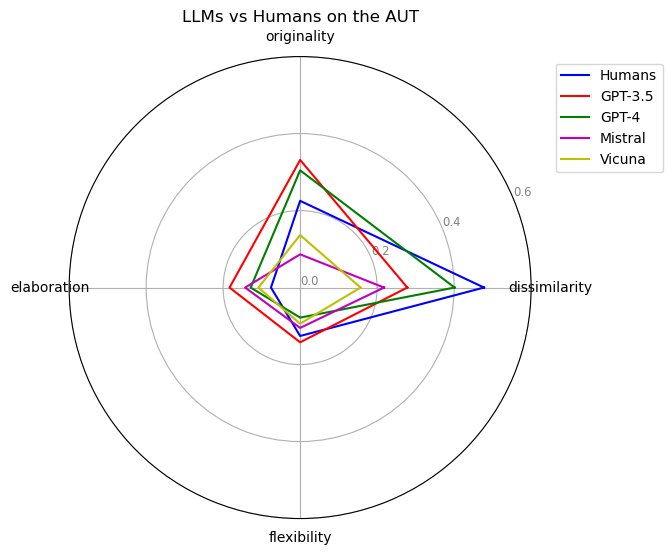

In [7]:
#features = ['prompt', 'originality', 'elaboration', 'elaboration_SW', 'cosine_dist']
#features = ['prompt', 'dissimilarity', 'originality', 'elaboration', 'elaboration_SW']
features = ['prompt', 'dissimilarity', 'originality', 'elaboration', 'flexibility']

humans_norm = combined_data_norm[combined_data_norm['dataset'] == 'Humans']
gpt_35_norm = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5']
gpt_4_norm = combined_data_norm[combined_data_norm['dataset'] == 'GPT-4']
mistral_norm = combined_data_norm[combined_data_norm['dataset'] == 'Mistral']
vicuna_norm = combined_data_norm[combined_data_norm['dataset'] == 'Vicuna']

# List of dataframes and corresponding titles
dataframes = [humans_norm[features], gpt_35_norm[features], gpt_4_norm[features], mistral_norm[features], vicuna_norm[features]]
titles = ['Humans', 'GPT-3.5', 'GPT-4', 'Mistral', 'Vicuna']
colors = ['b', 'r', 'g', 'm', 'y']

# Plot radar chart for multiple dataframes
plot_radar_chart(dataframes, titles, colors, avg_per_object = True)

# Radar charts per object

Question: Given an object, how are humans and LLMs performing ? Is it different and how ? (along which dimensions ?)

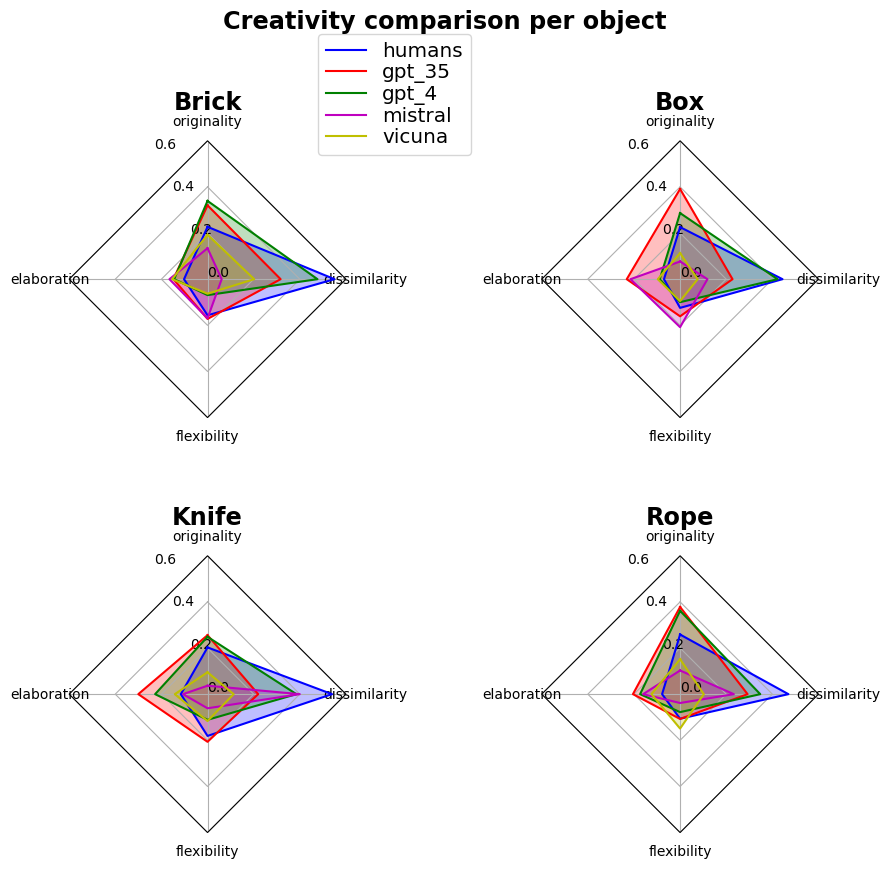

In [38]:
### PARAMETERS ###
data_dict = {"humans": humans, "gpt_35": gpt_35_processed, "gpt_4": gpt_4_processed, "mistral": mistral_processed, "vicuna": vicuna_processed}
features = ["originality", "elaboration", "flexibility", "dissimilarity"]
#################

objects = ["brick", "box", "knife", "rope"]
normalized_data = prepare_data_for_radar_chart_per_object(data_dict, objects)
brick_norm, box_norm, knife_norm, rope_norm = normalized_data["brick_norm"], normalized_data["box_norm"], normalized_data["knife_norm"], normalized_data["rope_norm"]
dataframes = [brick_norm, box_norm, knife_norm, rope_norm]
titles = data_dict.keys()

radar_charts_per_object(brick_norm, box_norm, knife_norm, rope_norm, features, model_names = list(data_dict.keys()))

# Radar charts per model

Question: 
- Are humans and LLMs more creative depending on the object ? What similarities and differences do they have ?
- Given a model, does the model performs differently depending on the object? And how ? (along which dimensions ?)

In [22]:
# normalize for each model across all objects
features = ["originality", "elaboration", "flexibility", "dissimilarity"]

humans_norm_per_model = normalization_per_model(humans)
gpt_35_norm_per_model = normalization_per_model(gpt_35_processed)
gpt_4_norm_per_model = normalization_per_model(gpt_4_processed)
mistral_norm_per_model = normalization_per_model(mistral_processed)
vicuna_norm_per_model = normalization_per_model(vicuna_processed)

# List of dataframes and corresponding titles
dataframes = [humans_norm_per_model[features], gpt_35_norm_per_model[features], gpt_4_norm_per_model[features], mistral_norm_per_model[features], vicuna_norm_per_model[features]]
titles = ['Humans', 'GPT-3.5', 'GPT-4', 'Mistral', 'Vicuna']

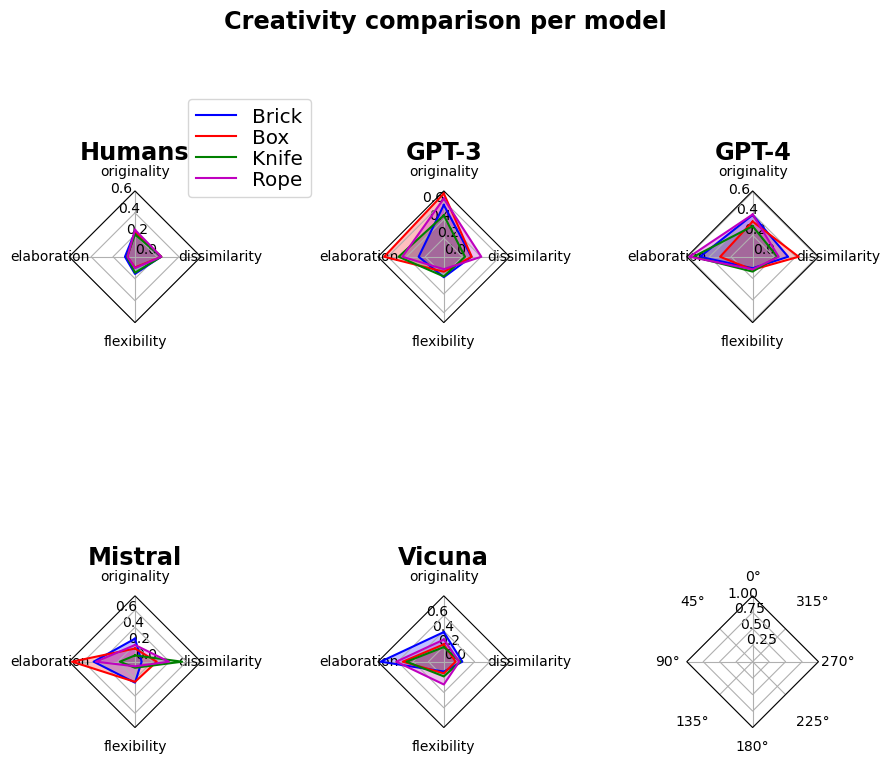

In [23]:
# dimensions to plot
#features_to_plot = ["originality", "elaboration", "elaboration_SW", "dissimilarity"]
features_to_plot = ["originality", "elaboration", "flexibility", "dissimilarity"]

radar_charts_per_model(humans_norm_per_model, gpt_35_norm_per_model, gpt_4_norm_per_model, mistral_norm_per_model, vicuna_norm_per_model, features_to_plot)

## Other plots

### Univariate analysis

In [24]:
def plot_per_object(type, data_dict, features, combined_data_norm_per_object):
    if type == "kde":
        for feat in features:
            fig, axs = plt.subplots(1, 4, figsize=(15, 5))
            for name, df in data_dict.items():
                for i, object in enumerate(['brick', 'box', 'knife','rope']):
                    sns.kdeplot(df[feat], label=name, ax = axs[i])
                    axs[i].set_title(object)
                    axs[i].legend()
        plt.suptitle(f"Comparison on {feat}")
        plt.tight_layout()
        plt.show()
    elif type == "boxplot":
        for feat in features:
            plt.figure(figsize=(12, 5))
            sns.boxplot(data=combined_data_norm_per_object, x='dataset', y=feat, hue = 'prompt')
            plt.suptitle(f"Comparison on {feat}")
            plt.tight_layout()
            plt.show()
    elif type == "violinplot":
        for feat in features:
            plt.figure(figsize=(12, 5))
            sns.violinplot(data=combined_data_norm_per_object, x='dataset', y=feat, hue = 'prompt')
            plt.suptitle(f"Comparison on {feat}")
            plt.tight_layout()
            plt.show()
    else:
        print("Wrong type of plot")
        return 0

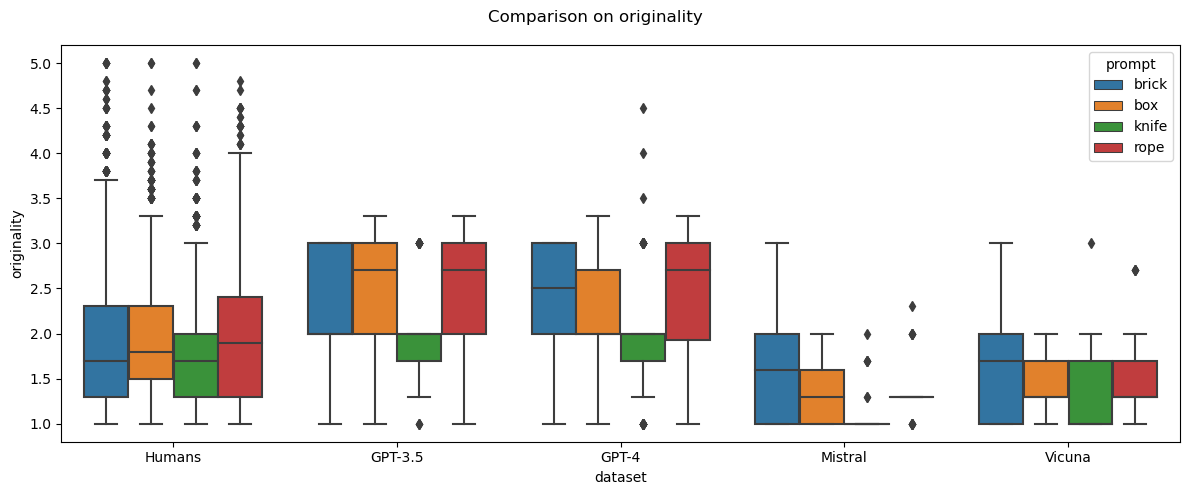

In [27]:
data_dict = {"humans": humans, "gpt_35": gpt_35_processed, "gpt_4": gpt_4_processed, "mistral": mistral_processed, "vicuna": vicuna_processed}

plot_per_object(type = "boxplot", data_dict = data_dict, features = ["originality"], combined_data_norm_per_object = combined_data)

### Test change flexibility scores

In [7]:
num_topics = 5
num_words = 10

dict_kw_coeff = run_LDA_on_humans_data(humans, num_topics, num_words, print_keywords = False, objects = objects)
#pprint(dict_kw_coeff[:num_topics]) # print coeff for the first object

Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in corpus for object "rope": 2048
Frequency of topics: [611, 745, 748, 1596, 877]
Frequency of topics: [624, 284, 269, 726, 364]
Frequency of topics: [321, 405, 362, 586, 646]
Frequency of topics: [467, 226, 175, 309, 563]


In [26]:
test_gpt35 = pd.read_csv('./data_processed/prompt_1/gpt35_merged_343.csv')
test_gpt35.head()

,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility
0,brick,Use it as a bookend for your shelves,1.0,8.0,3,0.200003,0.000000
1,brick,Paint and decorate it to use as a doorstop,2.0,9.0,4,0.181571,0.631315
2,brick,Create a makeshift dumbbell for light workouts,1.7,7.0,5,0.196846,0.785229
3,brick,Turn it into a unique paperweight for your desk,1.7,9.0,4,0.187414,0.785229
4,brick,Stack a few as a plant stand in the garden,2.0,10.0,4,0.241925,0.877696


In [27]:
# Flexibility
def compute_flexibility_score_custom(df, dict_kw_coeff, num_topics, objects, name_column):
    df_output = pd.DataFrame()
    for i, object in enumerate(objects):
        df_tmp = df[df['prompt'] == object]
        df_tmp[name_column] = df_tmp['response'].apply(lambda x: compute_originality_topic_sentence(x, dict_kw_coeff[i*num_topics:(i+1)*num_topics], num_topics))
        df_output = pd.concat([df_output, df_tmp])
    return df_output

print("Compute flexibility for 5 topics")
num_topics = 5
for num_words, name_col in zip([5, 10, 15], ['flexibility_5t_5kw', 'flexibility_5t_10kw', 'flexibility_5t_15kw']):
    dict_kw_coeff = run_LDA_on_humans_data(humans, num_topics, num_words, print_keywords = False, objects = objects)
    test_gpt35 = compute_flexibility_score_custom(test_gpt35, dict_kw_coeff, num_topics, objects, name_col)
    
print("Compute flexibility for 6 topics")
num_topics = 6
for num_words, name_col in zip([5, 10, 15], ['flexibility_6t_5kw', 'flexibility_6t_10kw', 'flexibility_6t_15kw']):
    dict_kw_coeff = run_LDA_on_humans_data(humans, num_topics, num_words, print_keywords = False, objects = objects)
    test_gpt35 = compute_flexibility_score_custom(test_gpt35, dict_kw_coeff, num_topics, objects, name_col)

print("Compute flexibility for 7 topics")
num_topics = 7
for num_words, name_col in zip([5, 10, 15], ['flexibility_7t_5kw', 'flexibility_7t_10kw', 'flexibility_7t_15kw']):
    dict_kw_coeff = run_LDA_on_humans_data(humans, num_topics, num_words, print_keywords = False, objects = objects)
    test_gpt35 = compute_flexibility_score_custom(test_gpt35, dict_kw_coeff, num_topics, objects, name_col)

test_gpt35.head()

Compute flexibility for 5 topics
Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in corpus for object "rope": 2048
Frequency of topics: [462, 414, 534, 1248, 727]
Frequency of topics: [521, 126, 179, 547, 200]
Frequency of topics: [204, 284, 220, 529, 517]
Frequency of topics: [384, 159, 54, 234, 402]
Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife": 2178
Number of documents in corpus for object "rope": 2048
Frequency of topics: [611, 745, 748, 1596, 877]
Frequency of topics: [624, 284, 269, 726, 364]
Frequency of topics: [321, 405, 362, 586, 646]
Frequency of topics: [467, 226, 175, 309, 563]
Number of documents in corpus for object "brick": 4056
Number of documents in corpus for object "box": 2703
Number of documents in corpus for object "knife"

,prompt,response,originality,elaboration,elaboration_SW,dissimilarity,flexibility,flexibility_5t_5kw,flexibility_5t_10kw,flexibility_5t_15kw,flexibility_6t_5kw,flexibility_6t_10kw,flexibility_6t_15kw,flexibility_7t_5kw,flexibility_7t_10kw,flexibility_7t_15kw
0,brick,Use it as a bookend for your shelves,1.0,8.0,3,0.200003,0.000000,0.000000,0.000000,0.624627,0.000000,0.750929,1.671134,0.000000,0.785497,0.794757
1,brick,Paint and decorate it to use as a doorstop,2.0,9.0,4,0.181571,0.631315,0.631315,2.139174,2.718470,1.610276,3.283012,3.280807,1.336346,4.072999,4.885574
2,brick,Create a makeshift dumbbell for light workouts,1.7,7.0,5,0.196846,0.785229,0.785229,0.808390,1.661638,0.701754,0.761229,0.763863,0.845861,0.857532,1.737833
3,brick,Turn it into a unique paperweight for your desk,1.7,9.0,4,0.187414,0.785229,0.785229,0.808390,2.945799,1.646115,2.445626,3.362754,0.668173,2.278197,2.306054
4,brick,Stack a few as a plant stand in the garden,2.0,10.0,4,0.241925,0.877696,0.877696,0.837230,1.458867,0.882707,1.564336,1.573783,1.771884,1.661640,2.524044


In [28]:
print(f"Percentage of ideas with 0 flexibility with 5 topics, 5 kw: {np.round(len(test_gpt35[test_gpt35['flexibility'] == 0])/len(test_gpt35)*100,2)}%")
print(f"Percentage of ideas with 0 flexibility with 5 topics, 10 kw: {np.round(len(test_gpt35[test_gpt35['flexibility_5t_10kw'] == 0])/len(test_gpt35)*100,2)}%")
print(f"Percentage of ideas with 0 flexibility with 5 topics, 15 kw: {np.round(len(test_gpt35[test_gpt35['flexibility_5t_15kw'] == 0])/len(test_gpt35)*100,2)}%")
print(f"Percentage of ideas with 0 flexibility with 6 topics, 5 kw: {np.round(len(test_gpt35[test_gpt35['flexibility_6t_5kw'] == 0])/len(test_gpt35)*100,2)}%")
print(f"Percentage of ideas with 0 flexibility with 6 topics, 10 kw: {np.round(len(test_gpt35[test_gpt35['flexibility_6t_10kw'] == 0])/len(test_gpt35)*100,2)}%")
print(f"Percentage of ideas with 0 flexibility with 6 topics, 15 kw: {np.round(len(test_gpt35[test_gpt35['flexibility_6t_15kw'] == 0])/len(test_gpt35)*100,2)}%")
print(f"Percentage of ideas with 0 flexibility with 7 topics, 5 kw: {np.round(len(test_gpt35[test_gpt35['flexibility_7t_5kw'] == 0])/len(test_gpt35)*100,2)}%")
print(f"Percentage of ideas with 0 flexibility with 7 topics, 10 kw: {np.round(len(test_gpt35[test_gpt35['flexibility_7t_10kw'] == 0])/len(test_gpt35)*100,2)}%")
print(f"Percentage of ideas with 0 flexibility with 7 topics, 15 kw: {np.round(len(test_gpt35[test_gpt35['flexibility_7t_15kw'] == 0])/len(test_gpt35)*100,2)}%")


Percentage of ideas with 0 flexibility with 5 topics, 5 kw: 41.11%
Percentage of ideas with 0 flexibility with 5 topics, 10 kw: 24.2%
Percentage of ideas with 0 flexibility with 5 topics, 15 kw: 14.58%
Percentage of ideas with 0 flexibility with 6 topics, 5 kw: 38.48%
Percentage of ideas with 0 flexibility with 6 topics, 10 kw: 15.74%
Percentage of ideas with 0 flexibility with 6 topics, 15 kw: 8.45%
Percentage of ideas with 0 flexibility with 7 topics, 5 kw: 32.07%
Percentage of ideas with 0 flexibility with 7 topics, 10 kw: 13.12%
Percentage of ideas with 0 flexibility with 7 topics, 15 kw: 7.29%


### Multi-variate analysis

**kdeplots between 2 features**

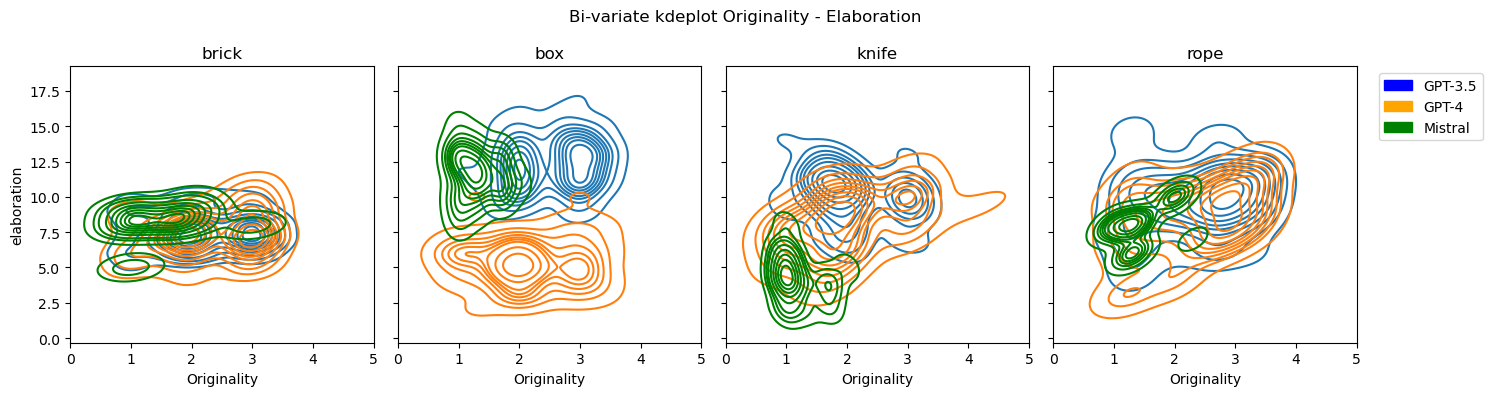

In [28]:
import matplotlib.patches as mpatches

# relation between originality and elaboration
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)

    # Define custom legend handles
legend_handles = [
    mpatches.Patch(color='blue', label='GPT-3.5'),
    mpatches.Patch(color='orange', label='GPT-4'),
    mpatches.Patch(color='green', label='Mistral')
]

objects = ['brick', 'box', 'knife', 'rope']
for i, object_name in enumerate(objects):

    object_gpt_35 = gpt_35_processed[gpt_35_processed['prompt'] == object_name]
    object_gpt_4 = gpt_4_processed[gpt_4_processed['prompt'] == object_name]
    object_mistral = mistral_processed[mistral_processed['prompt'] == object_name]
    
    #sns.kdeplot(x = object_ground_truth['target'], y = object_ground_truth['elaboration'], label=f'Humans, N = {len(object_ground_truth)}', ax = axs[i])
    sns.kdeplot(x = object_gpt_35['originality'], y = object_gpt_35['elaboration'], label='GPT-3.5', ax = axs[i])
    sns.kdeplot(x = object_gpt_4['originality'], y = object_gpt_4['elaboration'], label='GPT-4', ax = axs[i])
    sns.kdeplot(x = object_mistral['originality'], y = object_mistral['elaboration'], label='Mistral', ax = axs[i],color = 'green')
    
    axs[i].set_title(f'{object_name}')
    axs[i].set_xlabel('Originality')
    axs[i].set_xlim([0,5])
    
#plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))
# Add custom legend with specified handles
plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.05, 1.0))
plt.suptitle(f'Bi-variate kdeplot Originality - Elaboration')
plt.tight_layout()
plt.show()

###

**Correlation between dimensions**

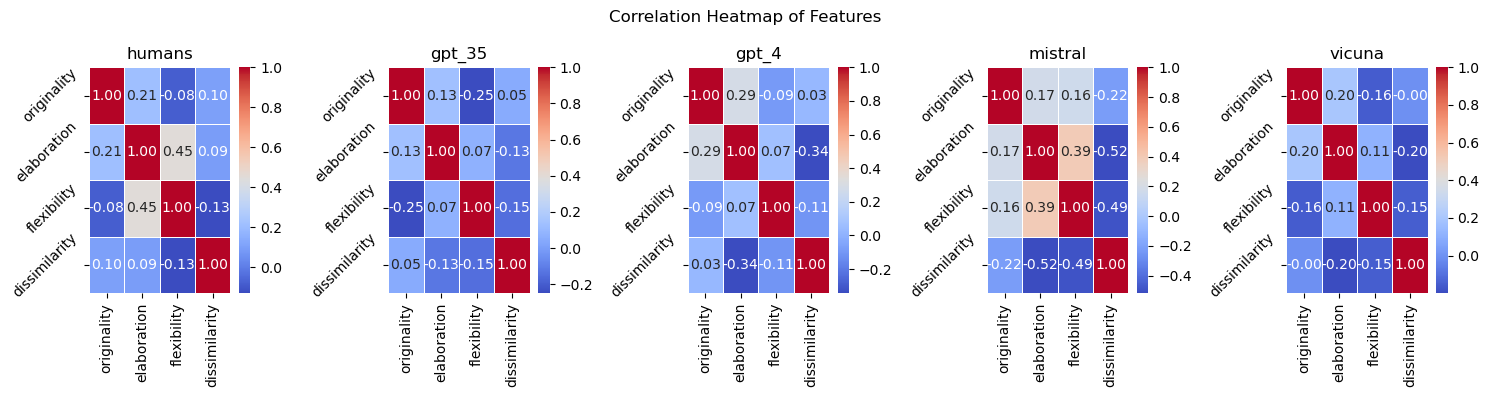

In [148]:
data_dict = {"humans": humans, "gpt_35": gpt_35_processed, "gpt_4": gpt_4_processed, "mistral": mistral_processed, "vicuna": vicuna_processed}

features = ['originality', 'elaboration', 'flexibility', 'dissimilarity']
fig, axs = plt.subplots(1, len(data_dict), figsize=(15, 4))
i = 0
for name, df in data_dict.items():
    corr_matrix = df[features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax = axs[i])
    axs[i].set_title(name)
    axs[i].tick_params(axis = 'y', rotation = 45)
    i += 1
plt.suptitle('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

---

# ANALYSIS

Organization:
- POS Tagging
- Topic Modeling (Flexibility)

### POS tagging

In [16]:
df_pos = compute_pos_tagging(combined_data)

100%|██████████| 94/94 [00:00<00:00, 1545.04it/s]


POS tagging: [ 4.83286299 11.54798762  9.68055556  8.36666667  6.23404255]
Ground truth: [4.699044151115157, 10.526315789473685, 8.636111111111111, 8.0, 6.23404255319149]


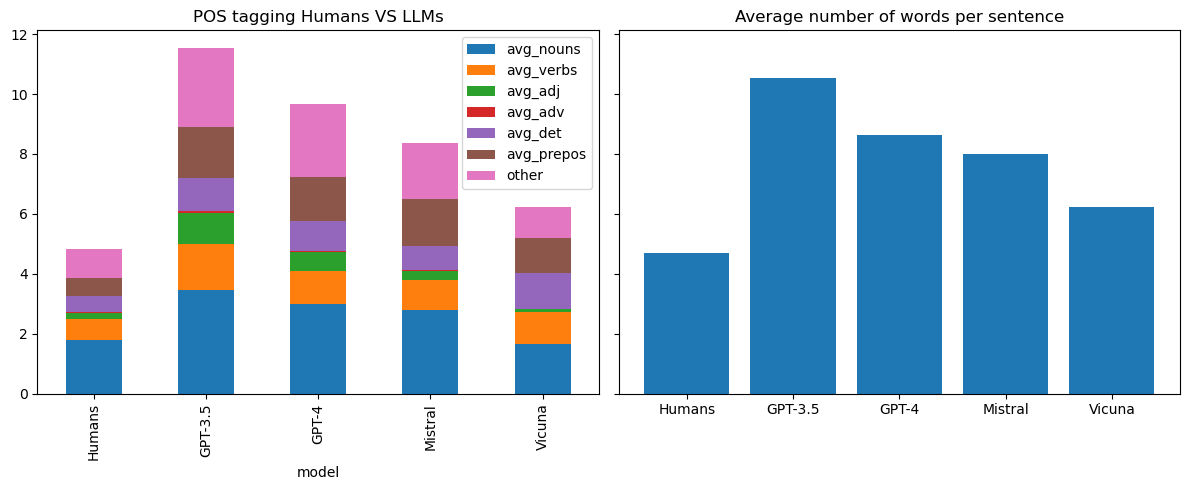

In [17]:
plot_POS(combined_data, df_pos)

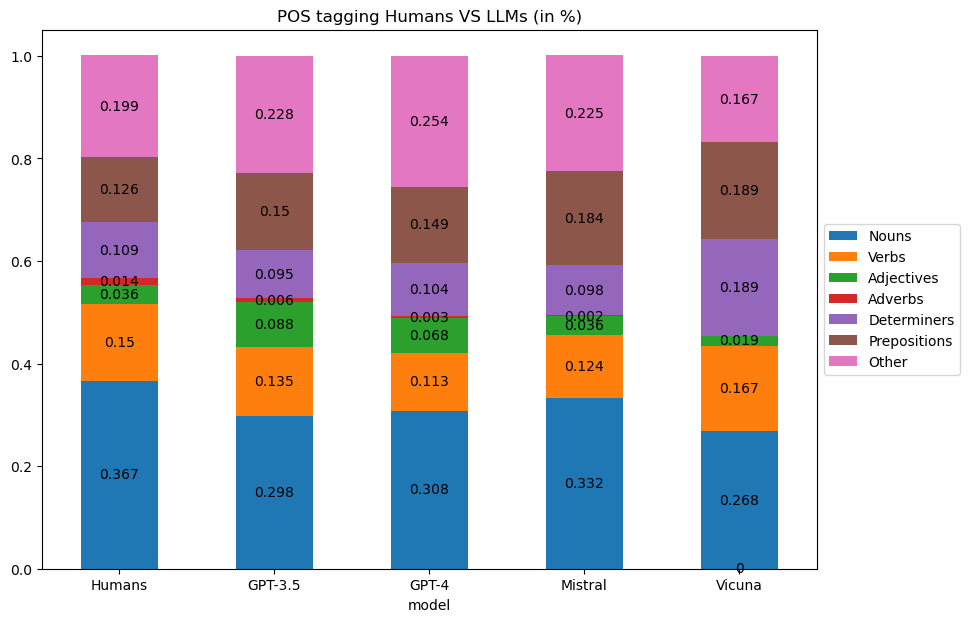

In [18]:
plot_POS_proportions(df_pos)

In [83]:
df_topic_score = compute_flexibility_score(humans, dict_kw_coeff, num_topics, objects)
df_topic_score = compute_flexibility_augmented_score(df_topic_score, dict_kw_coeff, num_topics, objects)
print("Length dataframe:", len(df_topic_score))
df_topic_score.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Length dataframe: 10985


,prompt,response,originality,elaboration,dissimilarity,elaboration_SW,flexibility,flexibility_augmented
0,brick,strength tester (punching),2.7,5,0.294817,5,0,0.000000
1,brick,art,2.1,1,0.330149,1,0,0.000000
2,brick,pencil holder,2.1,2,0.246490,2,1,0.877696
3,brick,writing utensil,2.1,2,0.232353,2,0,0.000000
4,brick,earrings,2.2,1,0.275411,1,0,0.000000


In [79]:
print(len(df_topic_score[df_topic_score['flexibility'] == 0]))
print(len(df_topic_score[df_topic_score['flexibility_augmented'] == 0]))

5971
5971


0.4332515384262847


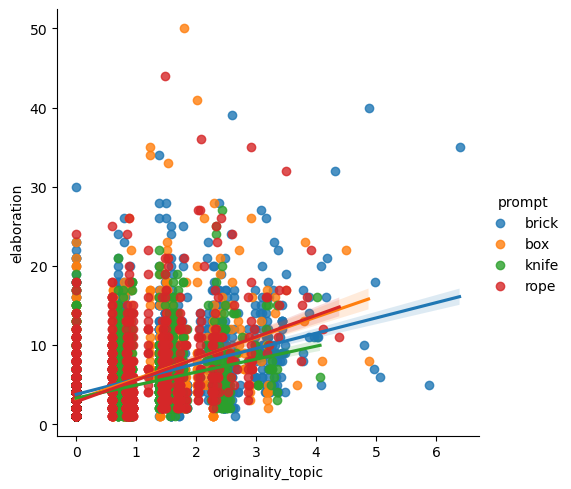

In [129]:
print(df_topic_score['originality_topic'].corr(df_topic_score['elaboration']))
sns.lmplot(x='originality_topic', y='elaboration', data=df_topic_score, hue = 'prompt')

In [30]:
correlation = humans['originality'].corr(humans['elaboration'])
print(correlation)

0.21353032154843288
